In [87]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
%autoreload 1
%aimport MLP
import numpy as np
import matplotlib.pyplot as plt
import struct

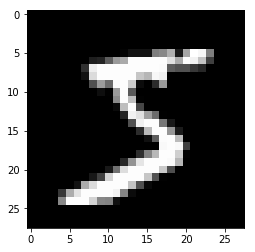

In [155]:
%matplotlib inline
with open('data/train-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    x_train_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    x_train_raw = x_train_raw.reshape((size, nrows, ncols))
    
plt.imshow(x_train_raw[0,:,:], cmap='gray')
plt.show()

In [156]:
with open('data/train-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    
y_train_raw[0]

5

In [157]:
from sklearn.preprocessing import OneHotEncoder
y_train = OneHotEncoder(categories='auto', sparse=False).fit_transform(y_train_raw.reshape(-1, 1))
y_train = np.expand_dims(y_train, axis=1)
print(y_train[0])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


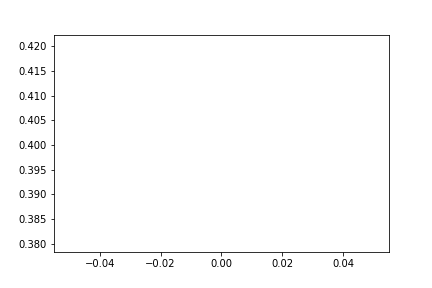

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


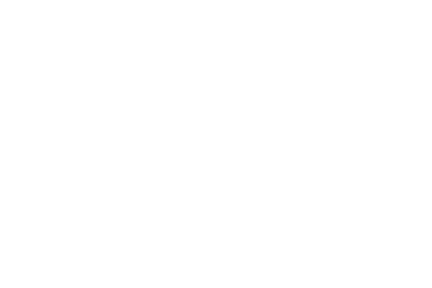

In [158]:
%matplotlib notebook
rng = np.random.RandomState(1234)

x_train = x_train_raw.reshape((x_train_raw.shape[0], 1, -1))

MLPclassifier = MLP.MLP(
    rng=rng,
    structure=(x_train.shape[2], 300, y_train.shape[2]),
    act_func=[MLP.Sigmoid(), MLP.Sigmoid()],
    criterion=MLP.CrossEntropy()
)

MLPclassifier.train(x_train, y_train, etta=0.01, plot=True)

In [103]:
with open('data/t10k-images-idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    x_test_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    x_test_raw = x_test_raw.reshape((size, nrows, ncols))
    
with open('data/t10k-labels-idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test_raw = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    
x_test = x_test_raw.reshape((x_test_raw.shape[0], 1, -1))
res = np.argmax(MLPclassifier.transform(x_test), axis=2).flatten()
(1 - np.equal(res, y_test_raw).sum() / res.size) * 100

12.029999999999996

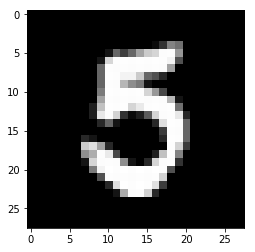

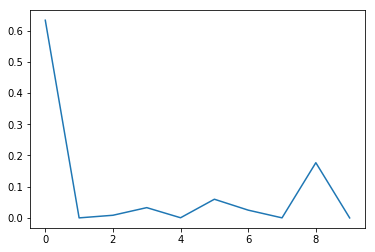

In [86]:
%matplotlib inline
neq = x_test_raw[np.not_equal(res, y_test_raw)]
i = np.asscalar(rng.choice(neq.shape[0], 1))
plt.imshow(neq[i], cmap='gray')
plt.show()
plt.plot(MLPclassifier.forward(neq[i].flatten()).flatten())
plt.show()